In [1]:
# Importantion des différentes librairies nécessaires

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
import matplotlib.transforms as mtransforms
from sklearn import tree
from IPython.display import SVG
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier 
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_fscore_support as class_report
from sklearn.metrics import top_k_accuracy_score as top_k
from sklearn.metrics import plot_confusion_matrix
from collections import OrderedDict
import shap

pip install 'aif360[AdversarialDebiasing]'


In [3]:
# Chargement des données

In [4]:
Raw = pd.read_csv('DESU_DS_ST2019_Data_TestStimUni.csv', sep = ',')

In [5]:
Data = Raw.copy()

In [6]:
Data.head()

,Unnamed: 0,Rat,Effectif,Group,Session,NP3_entry_time,NP3_exit_time,NP3_duration,Delay,NP3_relevancy,...,Response_entry_time,Response_duration,Response_correctness,Response_omission,RT,MT,Reward_omission,Feeder_entry_time,Feeder_duration,histo
0,0,c1r1,1.0,SHAM,1.0,8.09,8.17,0.08,1210.0,-1.0,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,HistoOk
1,1,c1r1,1.0,SHAM,1.0,9.93,11.37,1.44,1210.0,1.0,...,NaN,NaN,-1.0,1.0,NaN,NaN,NaN,NaN,NaN,HistoOk
2,2,c1r1,1.0,SHAM,1.0,18.73,20.09,1.36,1100.0,1.0,...,20.20,0.12,1.0,-1.0,0.27,0.11,-1.0,21.55,1.61,HistoOk
3,3,c1r1,1.0,SHAM,1.0,26.66,27.34,0.68,900.0,-1.0,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,HistoOk
4,4,c1r1,1.0,SHAM,1.0,32.06,33.29,1.23,900.0,1.0,...,33.39,0.09,1.0,-1.0,0.34,0.10,-1.0,34.57,2.06,HistoOk


In [7]:
Data.shape[0]

410036

In [8]:
Data.isnull().sum()*100/len(Data)

Unnamed: 0                   0.000000
Rat                          0.000000
Effectif                     0.000000
Group                        0.000000
Session                      0.000000
NP3_entry_time               0.000000
NP3_exit_time                0.000000
NP3_duration                 0.000000
Delay                        0.000000
NP3_relevancy                0.000000
Stimulus_apparition_time     0.000000
Intensity                    0.000000
Type_of_trial               32.091572
Rule_of_response             0.000000
Compatibility               32.091572
Anticipation                 0.000000
Response_side                0.000000
Response_entry_time         44.742169
Response_duration           44.742169
Response_correctness         0.000000
Response_omission            0.000000
RT                          44.742169
MT                          44.742169
Reward_omission             44.742169
Feeder_entry_time           56.371636
Feeder_duration             56.372123
histo       

In [9]:
Data.drop(['Unnamed: 0'], axis = 1, inplace =True) # colonne index

#Supression des essais fin de session pour lesquels une partie des variables n'a pas pu être enregistré (n = 235)
Data.drop(Data.loc[((Data.Type_of_trial.isnull())&(Data.NP3_relevancy == 1.)&(Data.Anticipation == 0.))].index, 
          inplace = True) 
#Supression des bugs d'acquisition
Data.drop(Data.loc[(Data.Anticipation == 1)&(Data.Compatibility.isnull() == False)].index, inplace = True)  # n = 2
Data.drop(Data.loc[(Data.Anticipation == 1)&(Data.NP3_relevancy == -1)].index, inplace = True) #n = 7
Data.drop(Data.loc[(Data.Response_omission == 1)&(Data.NP3_relevancy == -1)].index, inplace = True) #n = 52 
Data.drop(Data.loc[(Data.Response_correctness != 0)&(Data.NP3_relevancy == -1)].index, inplace = True) #n = 42 
Data.reset_index(drop = True, inplace = True)

#Suppression des variables décrivant les caractéristiques de l'essai, qui n'ont rien à voir avec l'animal et qui sont
#donc non pertinentes pour identifier la lésion.
Data.drop(['Effectif','Rule_of_response','histo','NP3_entry_time','NP3_exit_time','Delay','Stimulus_apparition_time','Response_entry_time','Feeder_entry_time'],
         axis = 1, inplace = True)

### Feature engineering

In [10]:
# Création d'une variable indiquant ce qui a été fait à l'essai précédent. l'essai précédent pourrait entrainer
# des comportements différents en fonction des types de lésion

#Création d'une variable essai qui nous servira ensuite à remonter d'un cran
I_NonRelevant = Data.loc[Data.NP3_relevancy == -1].index     
I_Ant = Data.loc[(Data.Anticipation == 1)].index
I_OmComp = Data.loc[(Data.Response_omission == 1)&(Data.Compatibility == 'compatible')].index
I_OmIncomp = Data.loc[(Data.Response_omission == 1)&(Data.Compatibility == 'incompatible')].index
I_CorIncomp = Data.loc[(Data.Response_correctness == 1)&(Data.Compatibility == 'incompatible')].index
I_CorComp = Data.loc[(Data.Response_correctness == 1)&(Data.Compatibility == 'compatible')].index
I_IncorComp = Data.loc[(Data.Response_correctness == -1)&(Data.Compatibility == 'compatible')&
         (Data.Response_omission == -1)].index
I_IncorIncomp = Data.loc[(Data.Response_correctness == -1)&(Data.Compatibility == 'incompatible')&
         (Data.Response_omission == -1)].index


In [11]:
Index = [I_NonRelevant,I_Ant,I_OmComp,I_OmIncomp,I_CorIncomp,I_CorComp,I_IncorComp,I_IncorIncomp]
Labels = ['NR','A','Oc','Oi','Ci','Cc','Ic','Ii']
Trial = pd.DataFrame()
for i in range(len(Index)):
    temp = pd.Series(data = np.repeat(Labels[i],len(Index[i])), index = Index[i])   
    Trial = pd.concat([Trial, temp])
Trial.sort_index(inplace = True)

In [12]:
Data['Trial'] = Trial   

In [13]:
#Création d'une variable essai précédent
Previous_trial = pd.DataFrame()
for rat in Data.Rat.unique():
    for Session in Data.Session.unique():
        temp = pd.Series(data = 'First', index = [0])
        temp = pd.concat([temp,Data.loc[(Data.Rat == rat)&(Data.Session == Session),'Trial'].iloc[:-1]])
        Previous_trial = pd.concat([Previous_trial,temp])
Previous_trial.reset_index(drop = True, inplace = True)

In [14]:
Data['Previous_trial'] = Previous_trial

### Standardisation des variables de temps

array([[<AxesSubplot:title={'center':'NP3_duration'}>,
        <AxesSubplot:title={'center':'Response_duration'}>],
       [<AxesSubplot:title={'center':'RT'}>,
        <AxesSubplot:title={'center':'MT'}>],
       [<AxesSubplot:title={'center':'Feeder_duration'}>, <AxesSubplot:>]],
      dtype=object)

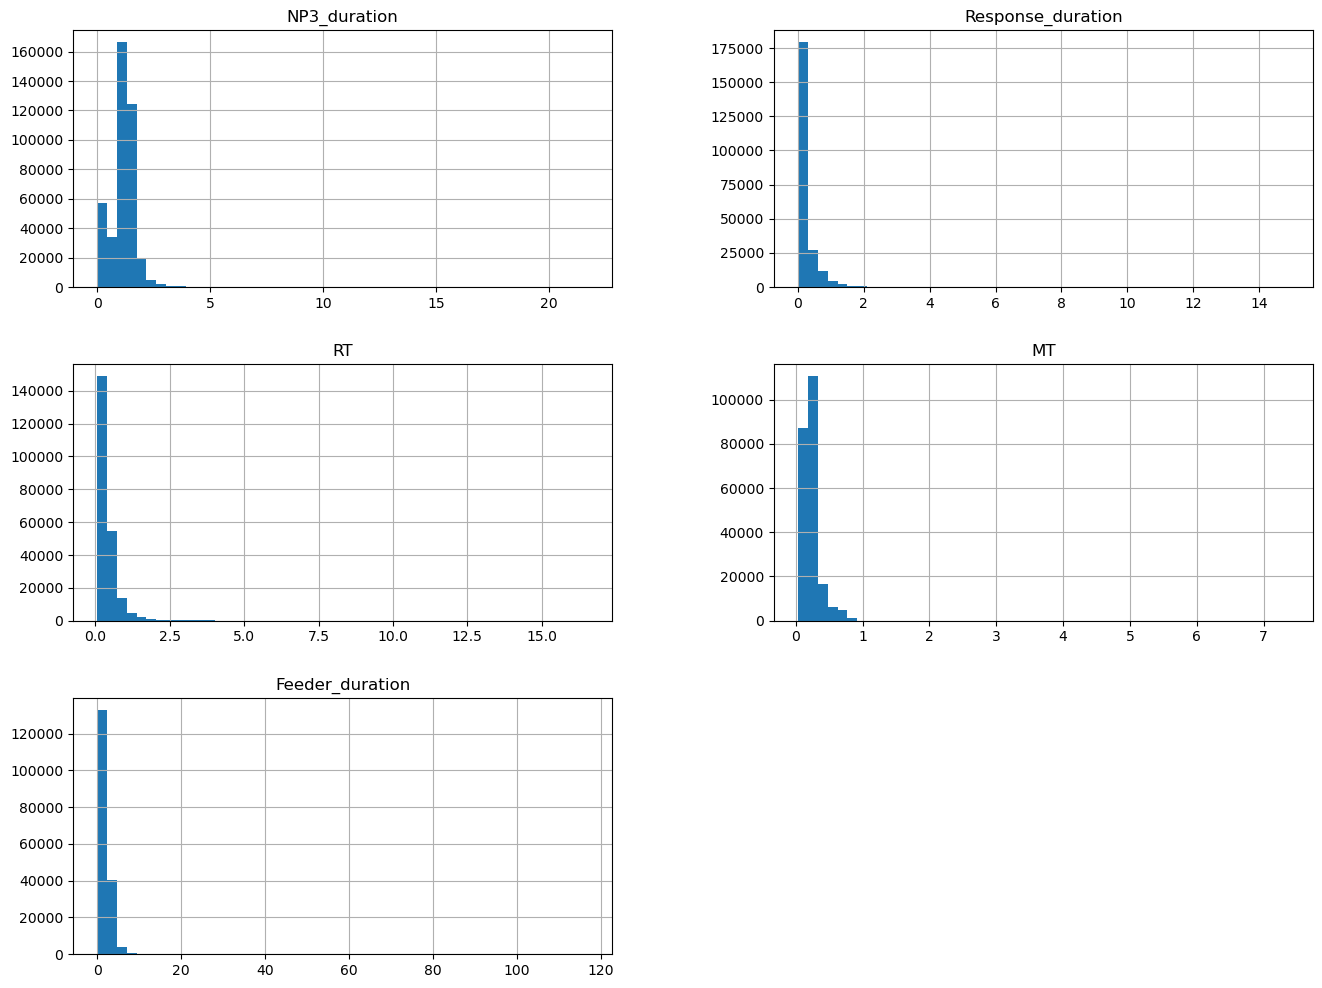

In [15]:
Data.hist(column=['NP3_duration','Response_duration','RT','MT','Feeder_duration'],figsize=(16, 12),bins = 50)

In [16]:
Data['logRT'] = np.log(Data.RT) # LogRT: utile pour la détection d'outliers, qui se fait sur des données normalisées.
Data['logNP3_duration'] = np.log(Data.NP3_duration)
Data['logResponse_duration'] = np.log(Data.Response_duration)
Data['logMT'] = np.log(Data.MT)
Data['logFeeder_duration'] = np.log(Data.Feeder_duration)

array([[<AxesSubplot:title={'center':'logNP3_duration'}>,
        <AxesSubplot:title={'center':'logResponse_duration'}>],
       [<AxesSubplot:title={'center':'logRT'}>,
        <AxesSubplot:title={'center':'logMT'}>],
       [<AxesSubplot:title={'center':'logFeeder_duration'}>,
        <AxesSubplot:>]], dtype=object)

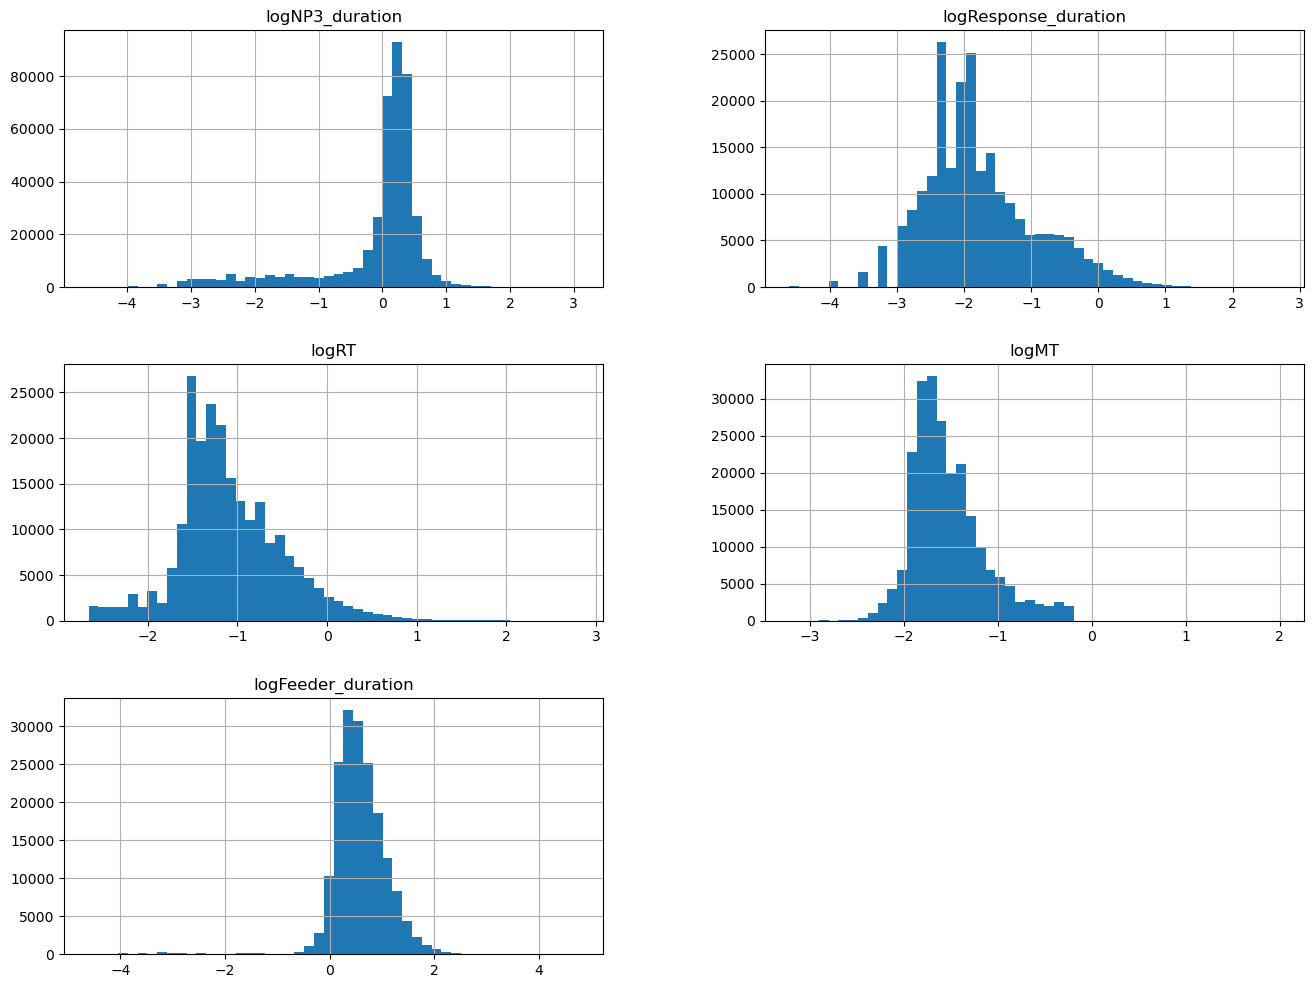

In [17]:
Data.hist(column=['logNP3_duration','logResponse_duration','logRT','logMT','logFeeder_duration'],figsize=(16, 12),bins = 50)

In [18]:
Data.drop(['NP3_duration','Response_duration','RT','MT','Feeder_duration'],axis = 1,inplace = True)

### Outliers management

In [19]:
def MADcutting (data, rats, dataRT, dataRats, dataCompatibility, dataCorrectness, LvLofDecision):
    '''
Détection des outliers dans la distribution de temps de réaction par la valeur absolue à la médiane
(Leys C. et al. 2013)
variables: data: le tableau de données entier; rats: une liste du nom des rats à traiter; 
dataRT: la colonne du tableau de donnée où se trouve les valeurs de RT;
dataRats: la colonnes du tableau où se trouve le nom des rats; 
dataCompatibility: la colonne du tableau où se trouve la compatibilité des essais;
dataCorrectness, justesse des réponse; LvLofDecision: nombre entier: correspond à la rigueur de la coupe par rapport 
à la médiane, d'après Leys C. et al. 3 correspond à une coupe très conservative, 2.5 moyennement et 2 faiblement
    ''' 

    correctness = [1,-1]
    compatibility = ['incompatible', 'compatible']
    DFInd = pd.DataFrame()

    for rat in rats:
        for i in correctness:
            for j in compatibility:
                RT_rat = dataRT[(dataRats==rat)&(dataCompatibility==j)&(dataCorrectness == i)&(dataRT.isnull() == False)] 
                if RT_rat.empty:
                    print ('warning empty: ',rat,i,j)
                    break
                med = np.median(RT_rat)
                abs_RT_rat = abs(RT_rat - med)
                abs_med = np.median(abs_RT_rat)
                b = 1.4826 #Constante pour une distribution normale(cf. Leys et al.2013)
                MAD = abs_med*b
                IndexToDrop = pd.Series(data[(dataRats==rat)&(dataCompatibility==j)&(dataCorrectness == i)&
                                   ((dataRT<np.median(RT_rat)-LvLofDecision*MAD)|
                                   (dataRT>np.median(RT_rat)+LvLofDecision*MAD))].index.values)
                DFInd = pd.concat([DFInd,IndexToDrop])

    return (DFInd) #Retourne les index des essais catégorisés comme ouliers parce que LvlofDecision * sup ou inf à la MAD

In [20]:
IndMAD = MADcutting(Data,Data.Rat.unique(),Data.logRT,Data.Rat,Data.Compatibility,Data.Response_correctness,2.5)

warning empty:  c37r1 -1 compatible


In [21]:
DataMAD = Data.drop(index = list(IndMAD[0]))

In [22]:
print('Pourcentage d\'essais supprimés après MAD cutting:',(len(IndMAD)/len(Data))*100)

Pourcentage d'essais supprimés après MAD cutting: 3.714931486119044


In [23]:
DataMAD.keys()

Index(['Rat', 'Group', 'Session', 'NP3_relevancy', 'Intensity',
       'Type_of_trial', 'Compatibility', 'Anticipation', 'Response_side',
       'Response_correctness', 'Response_omission', 'Reward_omission', 'Trial',
       'Previous_trial', 'logRT', 'logNP3_duration', 'logResponse_duration',
       'logMT', 'logFeeder_duration'],
      dtype='object')

### Dummies

In [24]:
D_Intensity = pd.get_dummies(DataMAD.Intensity)
D_Intensity.columns = ['Dim', 'Bright','NR_Int']
D_Type_of_trial = pd.get_dummies(DataMAD.Type_of_trial)
D_Type_of_trial.columns = ['BR','BL','DR','DL']
D_Compatibility = pd.get_dummies(DataMAD.Compatibility)
D_Response_side = pd.get_dummies(DataMAD.Response_side)
D_Response_side.columns = ['Response_left', 'NR_Side', 'Response_right']
D_Trial = pd.get_dummies(DataMAD.Trial)
D_Previous_Trial = pd.get_dummies(DataMAD.Previous_trial)
D_Previous_Trial.columns = ['Prev_A', 'Prev_Cc', 'Prev_Ci', 'Prev_First', 'Prev_Ic', 'Prev_Ii', 'Prev_NR', 'Prev_Oc',
                            'Prev_Oi']

In [25]:
DataDummies = pd.DataFrame()
DataDummies = DataMAD.drop(['Intensity', 'Type_of_trial','Compatibility','Response_side','Trial','Previous_trial'],
                          axis = 1)
DataDummies = pd.concat([DataDummies,D_Intensity,D_Type_of_trial,D_Compatibility,D_Response_side,D_Trial,
                         D_Previous_Trial],axis = 1)

### Rééquilibrage des effectifs

Il y a plus de SHAM dans le dataset, augmentant le nombre d'essais en leur faveur de près de 40000. On enlève donc 6 SHAM tirés aléatoirement pour rééquilibrer le nombre d'essais.

In [26]:
np.random.seed(11)
Rat_to_drop = np.random.choice(DataDummies.loc[DataDummies.Group == 'SHAM', 'Rat'].unique(), size = 6, replace = False)

In [27]:
Index_to_drop = DataDummies.loc[DataDummies.Rat.isin(Rat_to_drop)].index

In [28]:
DataFinale = DataDummies.drop(Index_to_drop)

In [29]:
print('nb d\'essais SHAM:',len(DataFinale.loc[DataFinale.Group == 'SHAM']))
print('nb d\'essais DMS:',len(DataFinale.loc[DataFinale.Group == 'DMS','Rat']))
print('nb d\'essais DLS:',len(DataFinale.loc[DataFinale.Group == 'DLS','Rat']))

nb d'essais SHAM: 111829
nb d'essais DMS: 110104
nb d'essais DLS: 124269


In [30]:
DataFinale.Group.replace(to_replace = {'SHAM':0,'DMS':1,'DLS':2 }, inplace = True) #Pour XGBoost

### Classification sur essais complets uniquement

In [357]:
D1 = DataFinale.loc[DataFinale.logRT.isnull() != True] #On ne conserve que les essais ayant aboutis à une réponse

In [358]:
D1 = D1.drop(['Rat','NP3_relevancy','Anticipation','Response_omission','logFeeder_duration','NR_Int','NR_Side','A','NR','Oc','Oi',
        'Prev_A','Prev_NR','Prev_Oc','Prev_Oi'],axis = 1) #On supprime les variables devenues obsolètes après cette 
#sélection des essais.

In [359]:
D1.isnull().sum()*100/len(D1) #Plus aucune valeur non atribuée dans le tableau

Group                   0.0
Session                 0.0
Response_correctness    0.0
Reward_omission         0.0
logRT                   0.0
logNP3_duration         0.0
logResponse_duration    0.0
logMT                   0.0
Dim                     0.0
Bright                  0.0
BR                      0.0
BL                      0.0
DR                      0.0
DL                      0.0
compatible              0.0
incompatible            0.0
Response_left           0.0
Response_right          0.0
Cc                      0.0
Ci                      0.0
Ic                      0.0
Ii                      0.0
Prev_Cc                 0.0
Prev_Ci                 0.0
Prev_First              0.0
Prev_Ic                 0.0
Prev_Ii                 0.0
dtype: float64

In [360]:
y = D1.Group #Variable à expliquer
X = D1.drop(['Group'],axis = 1) #Matrice de variables explicatives
#Séparation en set de données d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state = 1)

##### DecisionTreeClassifier

In [33]:
DTC = DecisionTreeClassifier(random_state=1)

In [130]:
DTC.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [131]:
y_pred = DTC.predict(X_test)
y_prob = DTC.predict_proba(X_test)
precision,recall,fscore,support=class_report(y_test,y_pred,average='macro')
top_k_acc = top_k(y_test,y_prob)
print(DTC)
print ('Precision : {}'.format(precision))
print ('Recall    : {}'.format(recall))
print ('F-score   : {}'.format(fscore))
print ('Top K Accuracy   : {}'.format(top_k_acc))
print('============================')

DecisionTreeClassifier(random_state=1)
Precision : 0.45957529229181254
Recall    : 0.4595853681842749
F-score   : 0.4595774859949892
Top K Accuracy   : 0.7246598965319027


In [ ]:
#Optimisation du modèle

In [189]:
max_depth = [13,14,15,16,17]
min_samples_split = [0.0001,0.0005,0.001,0.005]
min_samples_leaf = [57,58,59,60,61,62]
criterion = ['gini', 'entropy']
max_features = ['sqrt', 'log2', None]

In [190]:
param_grid = {
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf
    "criterion": criterion,
    "max_features" : max_features
}

In [191]:
gs = GridSearchCV(
    estimator=DTC,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=10,
    n_jobs=-1,
)

In [192]:
gs.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=DecisionTreeClassifier(max_depth=15,
                                              min_samples_split=0.001,
                                              random_state=1),
             n_jobs=-1,
             param_grid={'min_samples_leaf': [55, 56, 57, 58, 59, 60]},
             scoring='f1_macro')

In [199]:
gs.best_estimator_

DecisionTreeClassifier(max_depth=15, min_samples_leaf=60,
                       min_samples_split=0.001, random_state=1)

In [200]:
gs.best_score_

0.5198838852954749

In [201]:
DTC = gs.best_estimator_

In [202]:
y_pred = DTC.predict(X_test)
y_prob = DTC.predict_proba(X_test)
precision,recall,fscore,support=class_report(y_test,y_pred,average='macro')
top_k_acc = top_k(y_test,y_prob)
print(DTC)
print ('Precision : {}'.format(precision))
print ('Recall    : {}'.format(recall))
print ('F-score   : {}'.format(fscore)) #Amélioration du score f1 d'environ 6%
print ('Top K Accuracy   : {}'.format(top_k_acc))
print('============================')

DecisionTreeClassifier(max_depth=15, min_samples_leaf=60,
                       min_samples_split=0.001, random_state=1)
Precision : 0.5222502337244131
Recall    : 0.5215194130610626
F-score   : 0.5213857518498201
Top K Accuracy   : 0.8185202419730107


In [ ]:
#Matrice de confusion

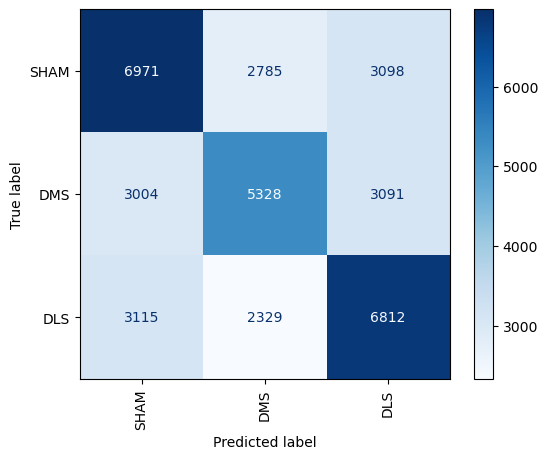

In [331]:
class_names = ['SHAM', 'DMS', 'DLS']
disp = plot_confusion_matrix(DTC, X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues, xticks_rotation='vertical')

In [ ]:
#Représentation de l'arbre de décision

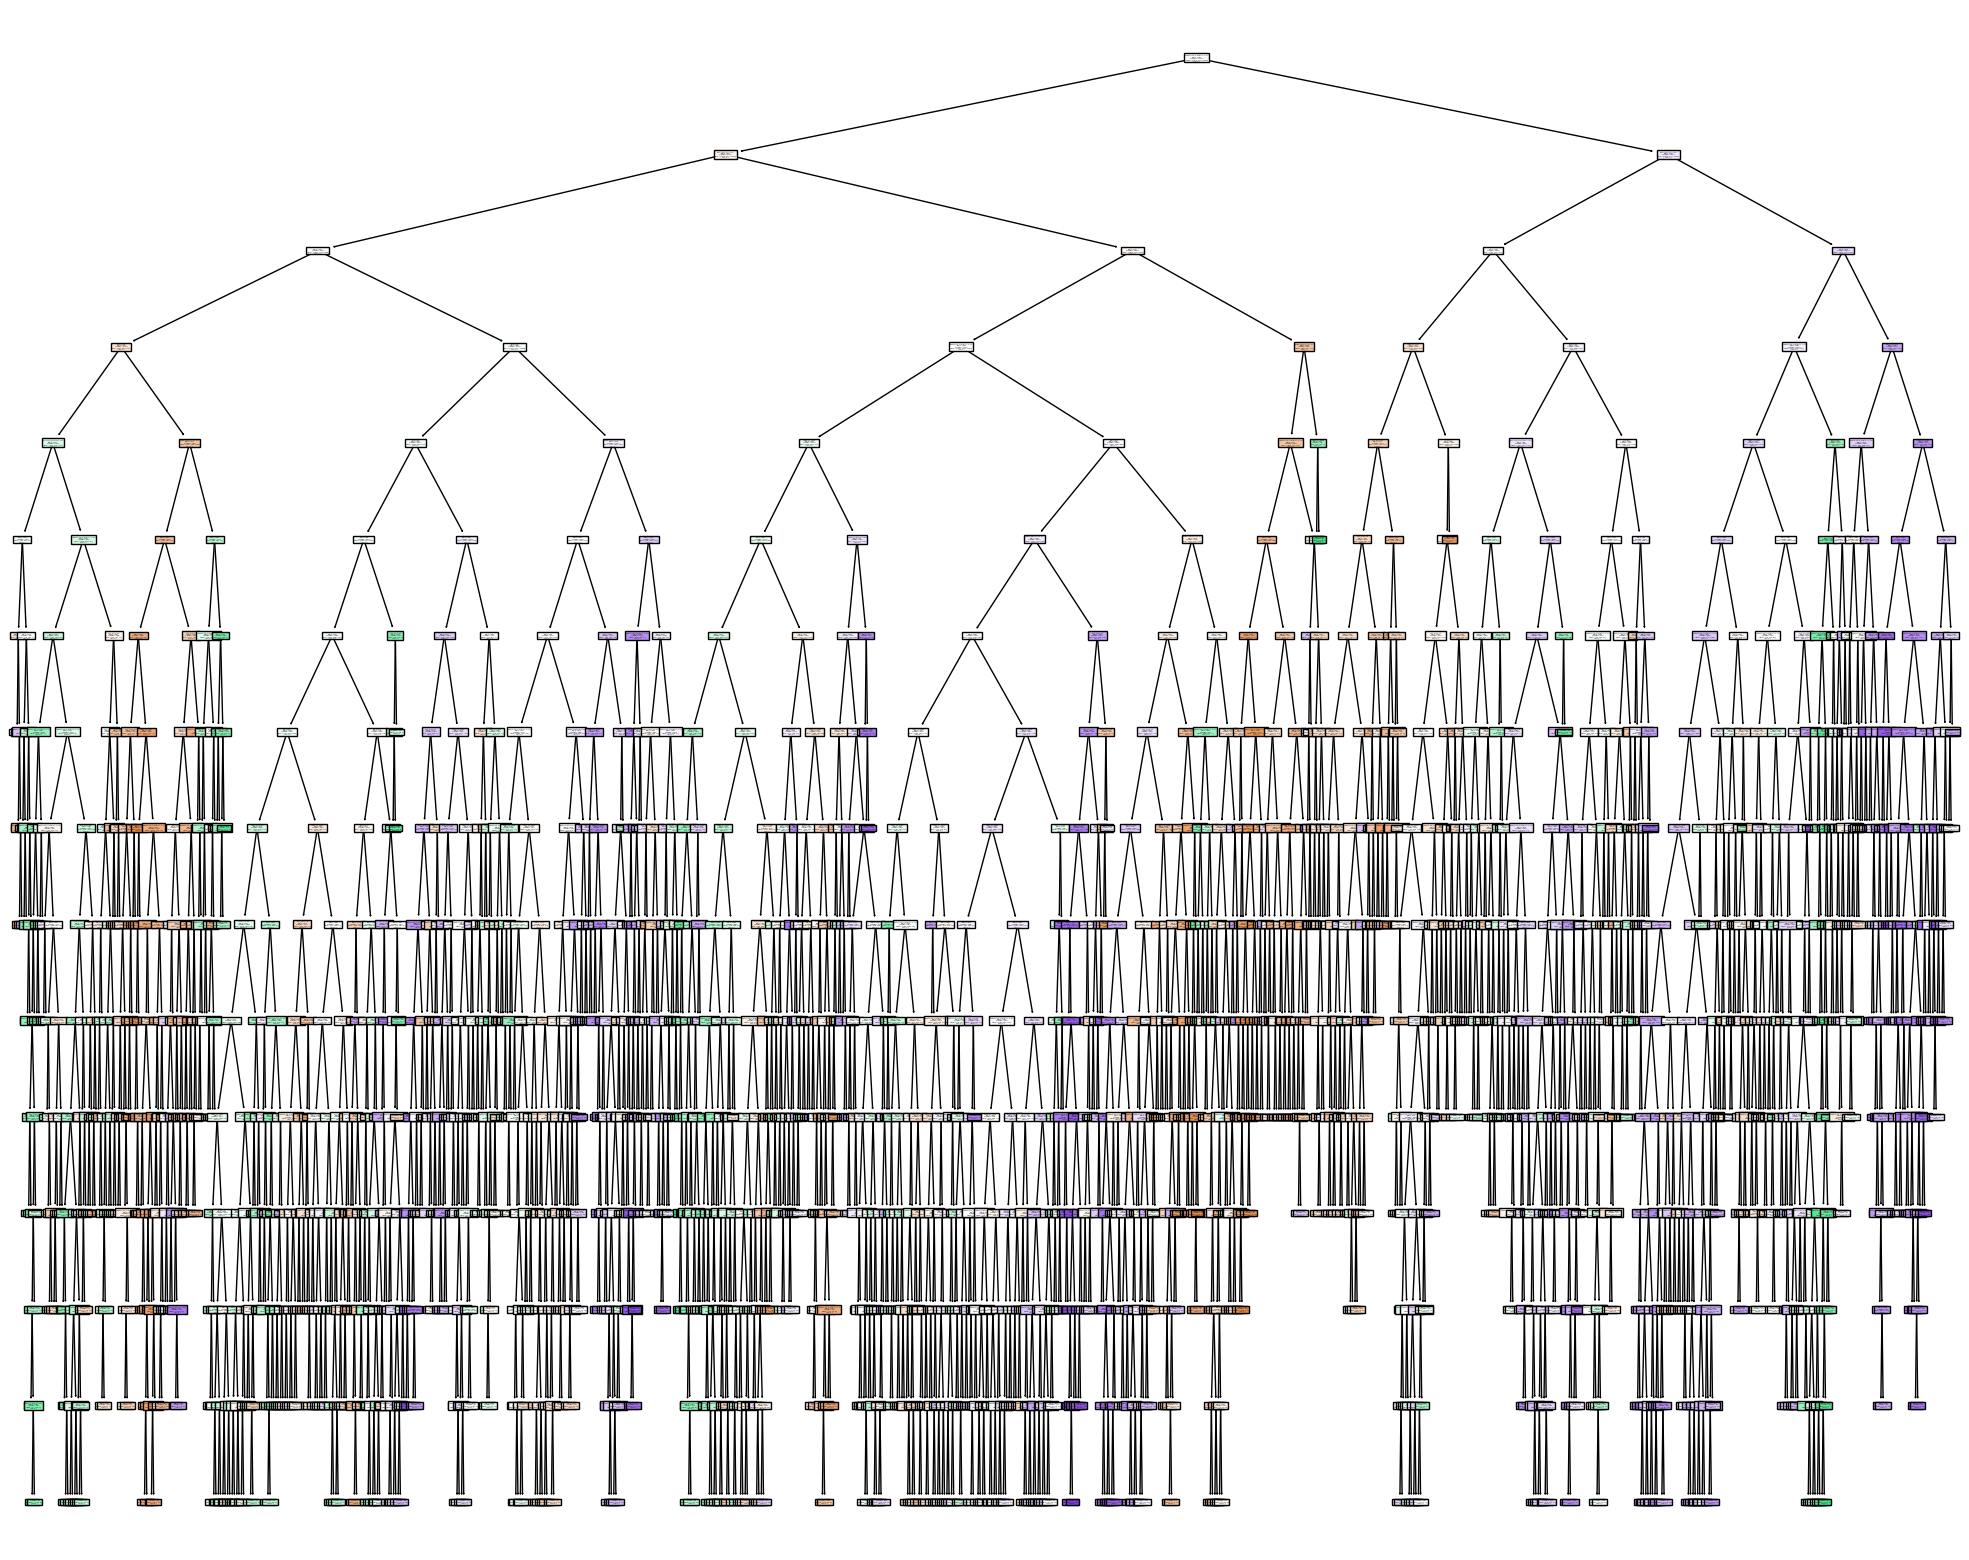

In [203]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(DTC, 
                   feature_names=X.columns,  
                   class_names=list(map(str,y.unique())),
                   filled=True)


In [ ]:
#Importances des variables

In [204]:
importances = DTC.feature_importances_
features = X_train.columns.tolist()
feature_importance = {}
for i, feature in enumerate(features):
    feature_importance[feature] = round(importances[i], 3)

In [205]:
feature_importance = pd.Series(feature_importance).reset_index(drop = False)
feature_importance.columns = ['features', 'importance']

In [206]:
feature_importance.sort_values(by = 'importance',ascending=False, inplace = True)

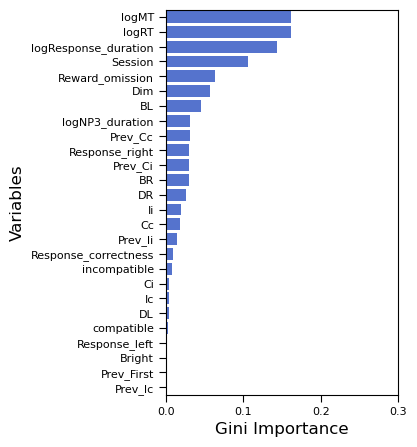

In [207]:
fig, axs = plt.subplots(figsize=(3,5))
sns.barplot(data = feature_importance, x = 'importance', y='features', color = 'royalblue') 
axs.tick_params(axis = 'both', which = 'both', labelsize = 8)
axs.tick_params(which = 'minor', length = 3)
axs.tick_params(which = 'major' , length = 5)
axs.set_xlabel('Gini Importance', fontsize = 12)
axs.set_ylabel('Variables', fontsize = 12)
axs.set_xticks(ticks = [0,0.1,0.2,0.3])
plt.show()

In [ ]:
#Courbes d'apprentissage

In [208]:
len(X_train)*0.8 #learning_curve sépare le jeu de données en entrainement et validation (80/20).  

116903.20000000001

In [209]:
#train_sizes n'a donc pas besoin d'être plus grand que 80% du dataset
train_sizes = [500,1000, 5000, 10000, 20000,40000,60000,80000,100000, 116903] 

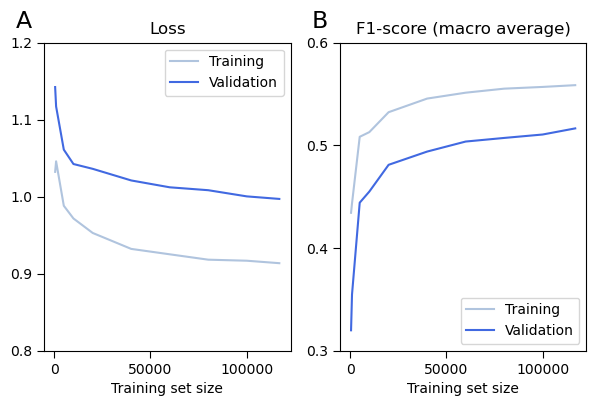

In [216]:
#Calcul des courbes et plot
fig, axs = plt.subplot_mosaic([['A', 'B']], figsize=(7,4))
ax_names = ['A','B']
score = ['neg_log_loss', 'f1_macro']

for i in range(2):
    if score[i] == 'neg_log_loss':
        neg = -1
    else:
        neg = 1
    train_sizes, train_scores, test_scores = \
    learning_curve(DTC, X_train, y_train, train_sizes=train_sizes, cv=5, scoring = score[i])
    sns.lineplot(x = train_sizes, y = np.mean(neg*train_scores,axis=1), 
                  ax =axs[ax_names[i]], color = 'lightsteelblue',label="Training")
    sns.lineplot(x = train_sizes, y = np.mean(neg*test_scores,axis=1),
                  ax =axs[ax_names[i]],color = 'royalblue',label="Validation")

for label, ax in axs.items():                         
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(0.0,1,label,transform=ax.transAxes + trans, fontsize = 17, va = 'bottom', 
            fontfamily =  'sans-serif')
    ax.set_xticks(ticks = [0,50000,100000])
    ax.tick_params(axis = 'both', which = 'both', labelsize = 10)
    ax.tick_params(which = 'major' , length = 5)
    ax.set_xlabel('Training set size')

axs['A'].set_yticks(ticks = [0.8,0.9,1,1.1,1.2])
axs['B'].set_ylim(top = 0.6)
axs['B'].set_yticks(ticks = [0.3,0.4,0.5,0.6])
axs['A'].set_title('Loss')
axs['B'].set_title('F1-score (macro average)')

plt.show()

##### Comparaison de modèles

In [217]:
#instanciation des modèles
SV = SVC(random_state = 1, probability=True)
KNC = KNeighborsClassifier()
RFC = RandomForestClassifier(random_state = 1)
ADA = AdaBoostClassifier(random_state = 1)
XGB = XGBClassifier(random_state = 1, objective = 'multi:softproba', num_class = 3)


In [218]:
# entraînement 
SV.fit(X_train,y_train)
KNC.fit(X_train,y_train)
RFC.fit(X_train,y_train)
ADA.fit(X_train,y_train)
XGB.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=1, ...)

In [220]:
list_of_models = [SV,KNC,RFC,ADA,XGB]
names = ['SV','KNC','RFC','ADA','XGB']

In [221]:
for m in list_of_models:
    y_pred = m.predict(X_test)
    y_prob = m.predict_proba(X_test)
    precision,recall,fscore,support=class_report(y_test,y_pred,average='macro')
    top_k_acc = top_k(y_test,y_prob)
    print(m)
    print ('Precision : {}'.format(precision))
    print ('Recall    : {}'.format(recall))
    print ('F-score   : {}'.format(fscore))
    print ('Top K Accuracy   : {}'.format(top_k_acc))
    print('============================')

SVC(probability=True, random_state=1)
Precision : 0.4152363834887496
Recall    : 0.39226970950363665
F-score   : 0.34956658608036567
Top K Accuracy   : 0.7266854624585991
KNeighborsClassifier()
Precision : 0.5042020155525058
Recall    : 0.4983334630213903
F-score   : 0.49752988000975057
Top K Accuracy   : 0.7981277201434319
RandomForestClassifier(random_state=1)
Precision : 0.5419935479501441
Recall    : 0.5414918456158797
F-score   : 0.5414767393416909
Top K Accuracy   : 0.8314400678838311
AdaBoostClassifier(random_state=1)
Precision : 0.4009089541112927
Recall    : 0.39918320499433335
F-score   : 0.3871546690814773
Top K Accuracy   : 0.7410012865080886
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_const

In [ ]:
#le RandomForestClassifier obtient les meilleures performances avec les paramètres par défaut.

###### Optimisation du modèle sélectionné

In [245]:
n_estimators = [30] 
max_depth = [22,23,24,25]
min_samples_split = [9e-05,1e-04,2e-04,3e-04]
min_samples_leaf = [1,2,3,4,5]
max_features =  ['sqrt', 'log2', None]

In [246]:
param_grid = {
    "n_estimators" : n_estimators,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
     "max_features" : max_features
}

In [247]:
gs = GridSearchCV(
    estimator=RFC,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=10,
    n_jobs=-1,
)

In [248]:
gs.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(max_depth=24, max_features='sqrt',
                                              min_samples_leaf=2,
                                              n_estimators=30, random_state=1),
             n_jobs=-1,
             param_grid={'min_samples_split': [9e-05, 0.0001, 0.0002, 0.0003]},
             scoring='f1_macro')

In [249]:
gs.best_estimator_

RandomForestClassifier(max_depth=24, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=0.0002, n_estimators=30,
                       random_state=1)

In [250]:
gs.best_score_

0.5491679198772106

In [ ]:
#Optimisation du nombre d'arbres

In [299]:
RFC = RandomForestClassifier(max_depth=24, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=0.0002,warm_start=True,oob_score=True,random_state=1)

In [300]:
error_rate = []
min_estimators = 15
max_estimators = 300
for i in range(min_estimators, max_estimators + 1, 5):
    RFC.set_params(n_estimators=i)
    RFC.fit(X_train, y_train)

    # Enregistre l'erreur OOB pour chaque n_estimators = i
    oob_error = 1 - RFC.oob_score_
    error_rate.append((i, oob_error))

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
invalid value encountered in true_divide
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
invalid value encountered in true_divide


In [301]:
xs,ys = [],[]
for i in range(len(error_rate)):
    a, b = zip(error_rate[i])
    xs.append(a[0])
    ys.append(b[0])

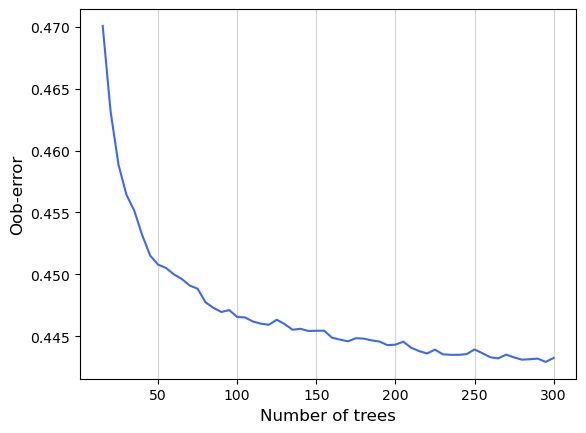

In [325]:
fig, ax = plt.subplots()
ax.plot(xs,ys, color = 'royalblue')
ax.set_ylabel('Oob-error', fontsize = 12)
ax.set_xlabel('Number of trees', fontsize = 12)
ax.grid(True, axis = 'x', color = 'lightgray')

In [361]:
RFC = RandomForestClassifier(max_depth=24, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=0.0002,n_estimators = 250,warm_start=True,oob_score=True,random_state=1)

In [362]:
RFC.fit(X_train,y_train)

RandomForestClassifier(max_depth=24, min_samples_leaf=2,
                       min_samples_split=0.0002, n_estimators=250,
                       oob_score=True, random_state=1, warm_start=True)

In [36]:
y_pred = RFC.predict(X_test)
y_prob = RFC.predict_proba(X_test)
precision,recall,fscore,support=class_report(y_test,y_pred,average='macro')
top_k_acc = top_k(y_test,y_prob)
print(RFC)
print ('Precision : {}'.format(precision))
print ('Recall    : {}'.format(recall))
print ('F-score   : {}'.format(fscore))
print ('Top K Accuracy   : {}'.format(top_k_acc))
print('============================')

RandomForestClassifier(max_depth=24, min_samples_leaf=2,
                       min_samples_split=0.0002, n_estimators=250,
                       oob_score=True, random_state=1, warm_start=True)
Precision : 0.5546239593715001
Recall    : 0.553085281037682
F-score   : 0.5528288831325571
Top K Accuracy   : 0.8436208359565325


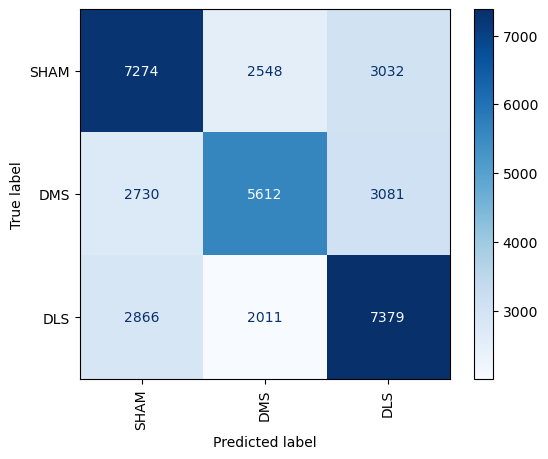

In [330]:
class_names = ['SHAM', 'DMS', 'DLS']
disp = plot_confusion_matrix(RFC, X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues, xticks_rotation='vertical')

In [39]:
explainer = shap.TreeExplainer(model = RFC,data = X_train)

In [ ]:
shap_values = explainer(X_train)

  0%|                   | 655/438387 [02:08<1425:41]       

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

### Classification de tous les essais avec XGBoost

In [41]:
D2 = DataFinale.loc[DataFinale.logRT.isnull() == True] #On ne conserve que les essais ayant aboutis à une réponse

In [42]:
D2 = D2.drop(['Rat','Reward_omission','logRT','logResponse_duration','logMT','logFeeder_duration','Response_correctness',
             'Response_left','Response_right'],axis = 1) #On supprime les variables devenues obsolètes après cette 
#sélection des essais.

In [43]:
D2.isnull().sum()*100/len(D2)

Group                0.0
Session              0.0
NP3_relevancy        0.0
Anticipation         0.0
Response_omission    0.0
logNP3_duration      0.0
Dim                  0.0
Bright               0.0
NR_Int               0.0
BR                   0.0
BL                   0.0
DR                   0.0
DL                   0.0
compatible           0.0
incompatible         0.0
NR_Side              0.0
A                    0.0
Cc                   0.0
Ci                   0.0
Ic                   0.0
Ii                   0.0
NR                   0.0
Oc                   0.0
Oi                   0.0
Prev_A               0.0
Prev_Cc              0.0
Prev_Ci              0.0
Prev_First           0.0
Prev_Ic              0.0
Prev_Ii              0.0
Prev_NR              0.0
Prev_Oc              0.0
Prev_Oi              0.0
dtype: float64

In [44]:
y = D2.Group
X = D2.drop(['Group'],axis = 1)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, stratify = y,random_state = 1)

In [208]:
#instanciation des modèles
DTC = DecisionTreeClassifier(random_state = 1)
RFC = RandomForestClassifier(random_state = 1)
XGB = XGBClassifier(random_state = 1, objective = 'multi:softproba', num_class = 3)

In [209]:
# entraînement 
DTC.fit(X_train,y_train)
RFC.fit(X_train,y_train)
XGB.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=1, ...)

In [210]:
list_of_models = [DTC,RFC,XGB]
names = ['DTC','RFC','XGB']

In [211]:
for m in list_of_models:
    y_pred = m.predict(X_test)
    y_prob = m.predict_proba(X_test)
    precision,recall,fscore,support=class_report(y_test,y_pred,average='macro')
    top_k_acc = top_k(y_test,y_prob)
    print(m)
    print ('Precision : {}'.format(precision))
    print ('Recall    : {}'.format(recall))
    print ('F-score   : {}'.format(fscore))
    print ('Top K Accuracy   : {}'.format(top_k_acc))
    print('============================')

DecisionTreeClassifier(random_state=1)
Precision : 0.36114335244689677
Recall    : 0.3615640466299492
F-score   : 0.3604379206197974
Top K Accuracy   : 0.7083588112999878
RandomForestClassifier(random_state=1)
Precision : 0.3676346015331344
Recall    : 0.36733096602850845
F-score   : 0.3669936063531274
Top K Accuracy   : 0.7072887367005014
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='m

In [ ]:
#XGBoost optient les meilleures performances

In [ ]:
#Optimisation

In [251]:
XGB = XGBClassifier(random_state = 1, objective = 'multi:softproba',num_class = 3,n_jobs=-1,eval_metric=['mlogloss'])
#Je garde le learning rate par défaut, 0.3, parce que j'ai peu de puissance de calcul. Je ne peux donc pas 
#me permettre d'augmenter beaucoup le nombre d'arbre du modèle.

In [252]:
evalset = [(X_train, y_train),(X_test,y_test)]
XGB.fit(X_train,y_train,eval_set = evalset)

[0]	validation_0-mlogloss:1.08886	validation_1-mlogloss:1.08978
[1]	validation_0-mlogloss:1.08249	validation_1-mlogloss:1.08436
[2]	validation_0-mlogloss:1.07815	validation_1-mlogloss:1.08074
[3]	validation_0-mlogloss:1.07501	validation_1-mlogloss:1.07822
[4]	validation_0-mlogloss:1.07270	validation_1-mlogloss:1.07638
[5]	validation_0-mlogloss:1.07085	validation_1-mlogloss:1.07505
[6]	validation_0-mlogloss:1.06931	validation_1-mlogloss:1.07413
[7]	validation_0-mlogloss:1.06807	validation_1-mlogloss:1.07347
[8]	validation_0-mlogloss:1.06675	validation_1-mlogloss:1.07277
[9]	validation_0-mlogloss:1.06560	validation_1-mlogloss:1.07207
[10]	validation_0-mlogloss:1.06477	validation_1-mlogloss:1.07158
[11]	validation_0-mlogloss:1.06396	validation_1-mlogloss:1.07131
[12]	validation_0-mlogloss:1.06277	validation_1-mlogloss:1.07083
[13]	validation_0-mlogloss:1.06216	validation_1-mlogloss:1.07073
[14]	validation_0-mlogloss:1.06134	validation_1-mlogloss:1.07048
[15]	validation_0-mlogloss:1.06098	

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=['mlogloss'], gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_class=3, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=1, ...)

In [ ]:
#Le nombre d'arbre optimal pour un learning rate de 0.3 est 40. Après quoi le modèle overfit et les performances
#diminues

In [254]:
results = XGB.evals_result()

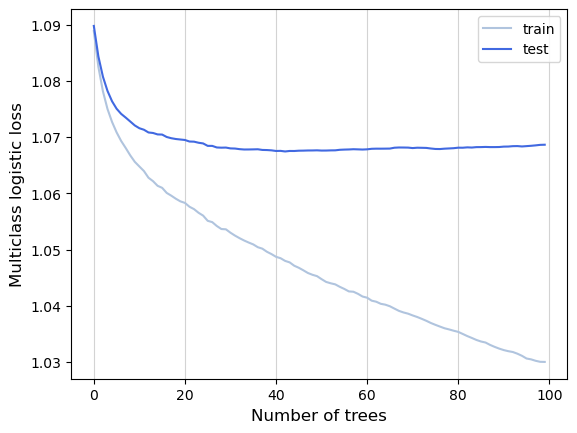

In [255]:
fig, ax  = plt.subplots()
ax.plot(results['validation_0']['mlogloss'],label = 'train', color = 'lightsteelblue')
ax.plot(results['validation_1']['mlogloss'], label = 'test', color = 'royalblue')
ax.set_ylabel('Multiclass logistic loss', fontsize = 12)
ax.set_xlabel('Number of trees', fontsize = 12) 
ax.grid(True, axis = 'x', color = 'lightgray')
plt.legend()
plt.show()

In [263]:
XGB = XGBClassifier(random_state = 1, objective = 'multi:softproba',num_class = 3,n_jobs=-1,eval_metric=['mlogloss'],
                   n_estimators = 40)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=['mlogloss'], gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=40, n_jobs=-1,
              num_class=3, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=1, ...)

In [298]:
param_grid = {
 'max_depth': [9,10,11,12],
 'min_child_weight':[0,0.0001,0.0005,0.001],
 'gamma':[0,0.1,0.2,0.3,0.4]
}

In [299]:
gs = GridSearchCV(
    estimator=XGB,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    n_jobs=-1,
)
gs.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric=['mlogloss'], gamma=0.2,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=10,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=40, n_jobs=-1, num_class=3,
                                     num_parallel_tree=None,
                                     objective='multi:softproba',
                                     predictor=None, random_state=1, ...),
             n_jobs=-1,
             param_grid={'min_child_weight': [0, 0.0001, 0.0005, 0.001]},
             scoring='f1_macro')

In [300]:
gs.best_score_

0.38163686040178374

In [301]:
gs.best_params_

{'min_child_weight': 0}

In [46]:
XGB = XGBClassifier(random_state = 1, objective = 'multi:softproba',num_class = 3,n_jobs=-1,eval_metric=['mlogloss'],
                   n_estimators = 40, max_depth = 10,min_child_weight = 0, gamma = 0.2)

In [47]:
XGB.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=['mlogloss'], gamma=0.2, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=10,
              max_leaves=0, min_child_weight=0, missing=nan,
              monotone_constraints='()', n_estimators=40, n_jobs=-1,
              num_class=3, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=1, ...)

In [48]:
y_pred = XGB.predict(X_test)
y_prob = XGB.predict_proba(X_test)
precision,recall,fscore,support=class_report(y_test,y_pred,average='macro')
top_k_acc = top_k(y_test,y_prob)
print(XGB)
print ('Precision : {}'.format(precision))
print ('Recall    : {}'.format(recall))
print ('F-score   : {}'.format(fscore))
print ('Top K Accuracy   : {}'.format(top_k_acc))
print('============================')

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=['mlogloss'], gamma=0.2, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=10,
              max_leaves=0, min_child_weight=0, missing=nan,
              monotone_constraints='()', n_estimators=40, n_jobs=-1,
              num_class=3, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=1, ...)
Precision : 0.40781096875370526
Recall    : 0.39601007826134
F-score   : 0.38384249277052246
Top K Accuracy   : 0.7422343157637276


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


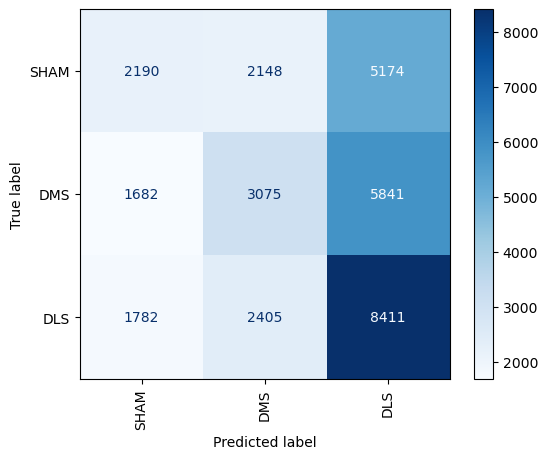

In [83]:
class_names = ['SHAM', 'DMS', 'DLS']
disp = plot_confusion_matrix(XGB, X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues, xticks_rotation='vertical')

In [101]:
print(len(y[y == 0])/(len(y[y == 2]))) #25% plus d'occurence DLS que SHAM
print(len(y[y == 1])/(len(y[y == 2]))) #15% plus que DMS

0.7550284961343684
0.8412154117254846


In [59]:
explainer_bis = shap.TreeExplainer(model = XGB, data = X_train)
shap_values_bis = explainer_bis.shap_values(X_train)

100%|===================| 392443/392496 [41:53<00:00]        

NameError: name 'shap_values' is not defined

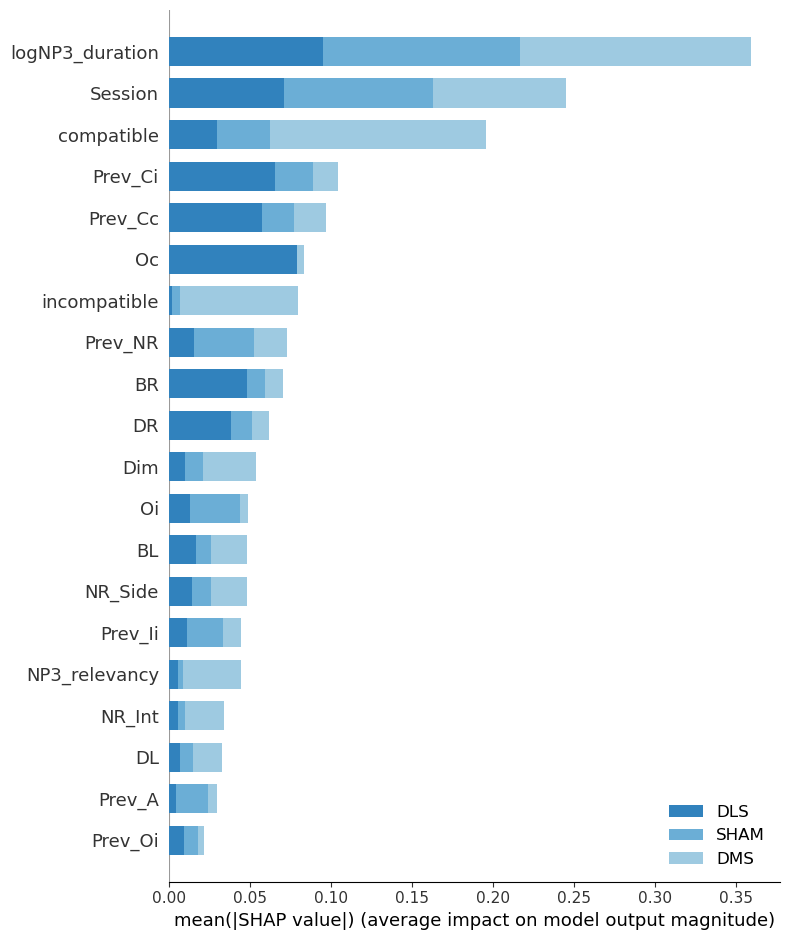

In [82]:
shap.summary_plot(shap_values_bis,X_test,plot_type="bar",color=plt.get_cmap("tab20c"), class_names=['SHAM', 'DMS','DLS'],
                 class_inds=[2,0,1])